# Multilevel Quasi-Monte Carlo Comparison

## Setup

In [1]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot

In [2]:
device = "cpu"
if device!="mps":
    torch.set_default_dtype(torch.float64)

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## Problem

In [4]:
levels = 4
n = np.array([2**14,2**12,2**10,2**8])
r = 8
n_r = n//r
d_coarsest = 2
f = qp.FinancialOption(
    sampler = qp.IIDStdUniform(dimension=d_coarsest),
    option = "ASIAN",
    call_put = "CALL",
    asian_mean = "GEOMETRIC",
    asian_mean_quadrature_rule = "RIGHT",
    volatility = .5,
    start_price = 39,
    strike_price = 40,
    interest_rate = 0.05,
    t_final = 1, 
    level = 0,
    d_coarsest = d_coarsest,
)
fs = [f]+f.spawn([l for l in range(1,levels)])
d = [fs[l].d for l in range(levels)]
exact_value_inf_dim = f.get_exact_value_inf_dim()
exact_values = np.array([0]+[fs[l].get_exact_value() for l in range(levels)])
exact_diffs = exact_values[1:]-exact_values[:-1]
for l in range(levels):
    print("l = %-7d d[l] = %-7d n[l] = %-7d n_r[l] = %-7d exact_diffs[l] = %-10.2e exact_values[l+1] = %-10.4f exact_value_inf_dim = %-10.4f"%(l,d[l],n[l],n_r[l],exact_diffs[l],exact_values[l+1],exact_value_inf_dim))

l = 0       d[l] = 2       n[l] = 16384   n_r[l] = 2048    exact_diffs[l] = 5.89e+00   exact_values[l+1] = 5.8860     exact_value_inf_dim = 3.9344    
l = 1       d[l] = 4       n[l] = 4096    n_r[l] = 512     exact_diffs[l] = -1.00e+00  exact_values[l+1] = 4.8832     exact_value_inf_dim = 3.9344    
l = 2       d[l] = 8       n[l] = 1024    n_r[l] = 128     exact_diffs[l] = -4.80e-01  exact_values[l+1] = 4.4027     exact_value_inf_dim = 3.9344    
l = 3       d[l] = 16      n[l] = 256     n_r[l] = 32      exact_diffs[l] = -2.36e-01  exact_values[l+1] = 4.1671     exact_value_inf_dim = 3.9344    


## IID Monte Carlo

In [5]:
print("MLMC-IID")
print("~"*25)
iid_samplers = qp.IIDStdUniform(d[0],seed=7)
iid_samplers = [iid_samplers] + iid_samplers.spawn(s=levels-1,dimensions=d[1:])
mlmc_approx = 0
mlmc_std_error = 0
for l in range(levels):
    x = iid_samplers[l](n[l])
    y = fs[l].f(x)
    delta = y[1]-y[0]
    mlmc_approx_l = np.mean(delta)
    mlmc_approx += mlmc_approx_l
    mlmc_std_error_l = delta.std(ddof=1)/np.sqrt(n[l])
    mlmc_std_error = np.sqrt(mlmc_std_error**2+mlmc_std_error_l**2)
    mlmc_true_error_l = np.abs(mlmc_approx_l-exact_diffs[l])
    mlmc_true_error = np.abs(mlmc_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(mlmc_true_error,mlmc_std_error,mlmc_approx,mlmc_true_error_l,mlmc_std_error_l,mlmc_approx_l,x.shape,y.shape,delta.shape))

MLMC-IID
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 1.86e+00   std_error = 8.87e-02   approx = 6.0298     error_l = 1.44e-01   std_error_l = 8.87e-02   approx_l = 6.0298     x.shape = (16384, 2)	y.shape = (2, 16384)	delta.shape = (16384,)  
error = 9.94e-01   std_error = 1.00e-01   approx = 5.1615     error_l = 1.34e-01   std_error_l = 4.66e-02   approx_l = -0.8683    x.shape = (4096, 4) 	y.shape = (2, 4096) 	delta.shape = (4096,)   
error = 5.10e-01   std_error = 1.10e-01   approx = 4.6774     error_l = 3.64e-03   std_error_l = 4.55e-02   approx_l = -0.4841    x.shape = (1024, 8) 	y.shape = (2, 1024) 	delta.shape = (1024,)   
error = 2.21e-01   std_error = 1.21e-01   approx = 4.3877     error_l = 5.41e-02   std_error_l = 4.93e-02   approx_l = -0.2897    x.shape = (256, 16) 	y.shape = (2, 256)  	delta.shape = (256,)    


## QMC and MLQMC

### Lattice

In [6]:
print("MLQMC-Lattice")
print("~"*25)
lattice_samplers_mlqmc = qp.Lattice(d[0],replications=r,seed=7)
lattice_samplers_mlqmc = [lattice_samplers_mlqmc]+lattice_samplers_mlqmc.spawn(s=levels-1,dimensions=d[1:])
mlqmc_lattice_approx = 0 
mlqmc_lattice_std_error = 0 
for l in range(levels):
    x = lattice_samplers_mlqmc[l](n_r[l])
    y = fs[l].f(x)
    delta = y[1]-y[0]
    muhats = delta.mean(-1)
    mlqmc_lattice_approx_l = muhats.mean()
    mlqmc_lattice_approx += mlqmc_lattice_approx_l
    mlqmc_lattice_std_error_l = muhats.std(ddof=1)/np.sqrt(r)
    mlqmc_lattice_std_error = np.sqrt(mlqmc_lattice_std_error**2+mlqmc_lattice_std_error_l**2)
    mlqmc_lattice_true_error_l = np.abs(mlqmc_lattice_approx_l-exact_diffs[l])
    mlqmc_lattice_true_error = np.abs(mlqmc_lattice_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(mlqmc_lattice_true_error,mlqmc_lattice_std_error,mlqmc_lattice_approx,mlqmc_lattice_true_error_l,mlqmc_lattice_std_error_l,mlqmc_lattice_approx_l,x.shape,y.shape,delta.shape))

MLQMC-Lattice
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 1.72e+00   std_error = 6.89e-03   approx = 5.8919     error_l = 5.95e-03   std_error_l = 6.89e-03   approx_l = 5.8919     x.shape = (8, 2048, 2)	y.shape = (2, 8, 2048)	delta.shape = (8, 2048) 
error = 7.24e-01   std_error = 1.19e-02   approx = 4.8914     error_l = 2.27e-03   std_error_l = 9.64e-03   approx_l = -1.0005    x.shape = (8, 512, 4)	y.shape = (2, 8, 512)	delta.shape = (8, 512)  
error = 2.83e-01   std_error = 2.29e-02   approx = 4.4500     error_l = 3.91e-02   std_error_l = 1.96e-02   approx_l = -0.4414    x.shape = (8, 128, 8)	y.shape = (2, 8, 128)	delta.shape = (8, 128)  
error = 5.32e-02   std_error = 3.57e-02   approx = 4.2203     error_l = 5.86e-03   std_error_l = 2.73e-02   approx_l = -0.2297    x.shape = (8, 32, 16)	y.shape = (2, 8, 32)	delta.shape = (8, 32)   


### Net

In [7]:
print("MLQMC-Net")
print("~"*25)
net_samplers_mlqmc = qp.DigitalNet(d[0],replications=r,seed=7)
net_samplers_mlqmc = [net_samplers_mlqmc]+net_samplers_mlqmc.spawn(s=levels-1,dimensions=d[1:])
mlqmc_net_approx = 0 
mlqmc_net_std_error = 0 
for l in range(levels):
    x = net_samplers_mlqmc[l](n_r[l])
    y = fs[l].f(x)
    delta = y[1]-y[0]
    muhats = delta.mean(-1)
    mlqmc_net_approx_l = muhats.mean()
    mlqmc_net_approx += mlqmc_net_approx_l
    mlqmc_net_std_error_l = muhats.std(ddof=1)/np.sqrt(r)
    mlqmc_net_std_error = np.sqrt(mlqmc_net_std_error**2+mlqmc_net_std_error_l**2)
    mlqmc_net_true_error_l = np.abs(mlqmc_net_approx_l-exact_diffs[l])
    mlqmc_net_true_error = np.abs(mlqmc_net_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(mlqmc_net_true_error,mlqmc_net_std_error,mlqmc_net_approx,mlqmc_net_true_error_l,mlqmc_net_std_error_l,mlqmc_net_approx_l,x.shape,y.shape,delta.shape))

MLQMC-Net
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 1.72e+00   std_error = 2.21e-03   approx = 5.8834     error_l = 2.60e-03   std_error_l = 2.21e-03   approx_l = 5.8834     x.shape = (8, 2048, 2)	y.shape = (2, 8, 2048)	delta.shape = (8, 2048) 
error = 7.12e-01   std_error = 4.87e-03   approx = 4.8790     error_l = 1.60e-03   std_error_l = 4.35e-03   approx_l = -1.0044    x.shape = (8, 512, 4)	y.shape = (2, 8, 512)	delta.shape = (8, 512)  
error = 2.27e-01   std_error = 8.07e-03   approx = 4.3941     error_l = 4.43e-03   std_error_l = 6.43e-03   approx_l = -0.4849    x.shape = (8, 128, 8)	y.shape = (2, 8, 128)	delta.shape = (8, 128)  
error = 2.93e-03   std_error = 3.42e-02   approx = 4.1642     error_l = 5.70e-03   std_error_l = 3.32e-02   approx_l = -0.2299    x.shape = (8, 32, 16)	y.shape = (2, 8, 32)	delta.shape = (8, 32)   


## Fast Independent GPs

### Lattice

FIGPs-Lattice
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 1.72e+00   std_error = 1.08e-03   approx = 5.8868     error_l = 8.17e-04   std_error_l = 1.08e-03   approx_l = 5.8868     x.shape = (16384, 2)	y.shape = (2, 16384)	delta.shape = (16384,)  
error = 7.14e-01   std_error = 5.65e-03   approx = 4.8815     error_l = 2.50e-03   std_error_l = 5.54e-03   approx_l = -1.0053    x.shape = (4096, 4) 	y.shape = (2, 4096) 	delta.shape = (4096,)   
error = 2.43e-01   std_error = 5.15e-02   approx = 4.4101     error_l = 9.10e-03   std_error_l = 5.12e-02   approx_l = -0.4714    x.shape = (1024, 8) 	y.shape = (2, 1024) 	delta.shape = (1024,)   
error = 4.89e-03   std_error = 1.19e-01   approx = 4.1720     error_l = 2.52e-03   std_error_l = 1.07e-01   approx_l = -0.2381    x.shape = (256, 16) 	y.shape = (2, 256)  	delta.shape = (256,)    


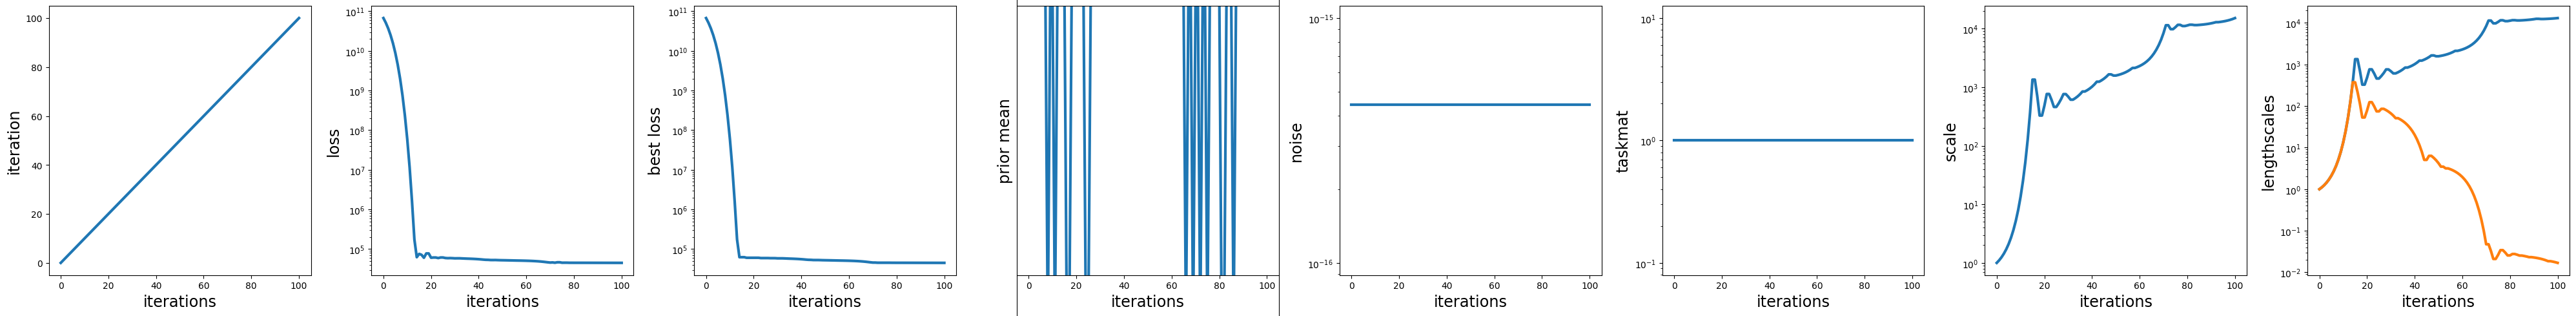

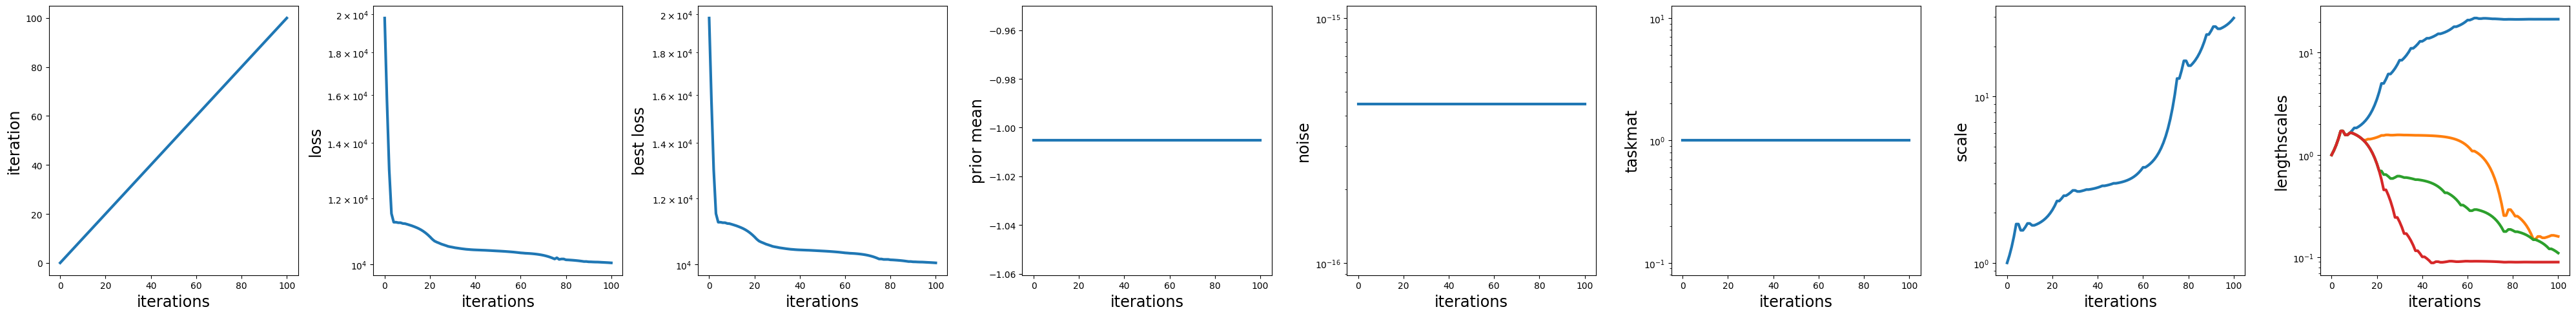

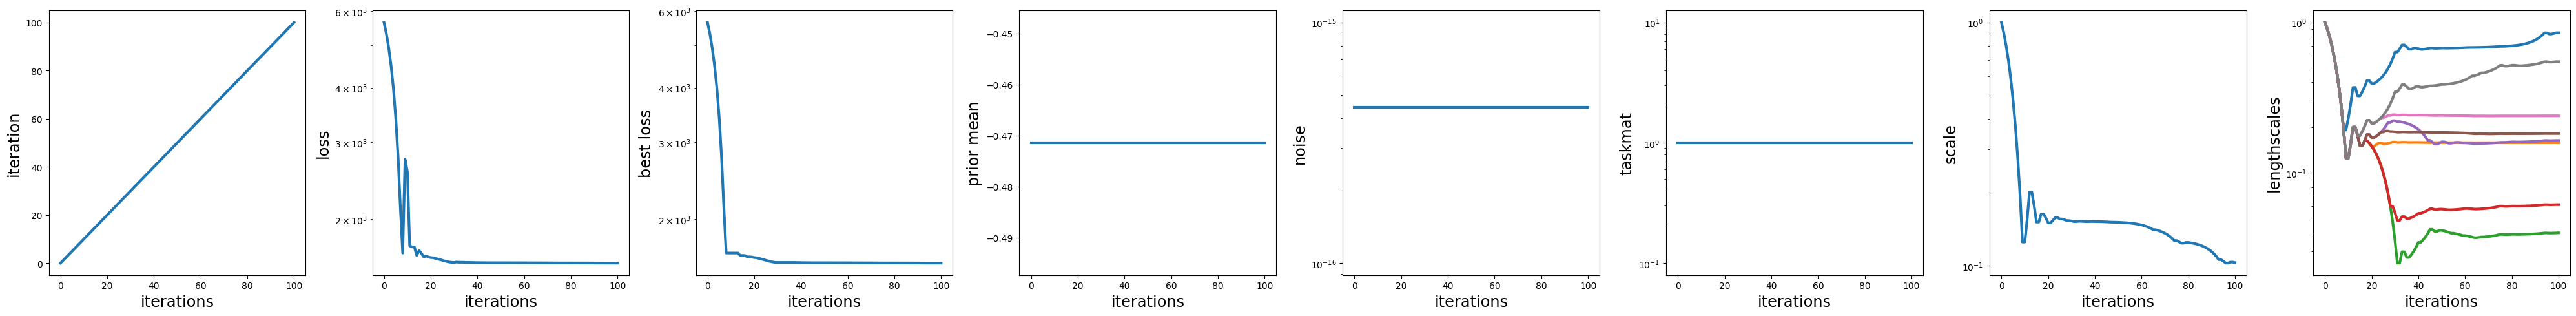

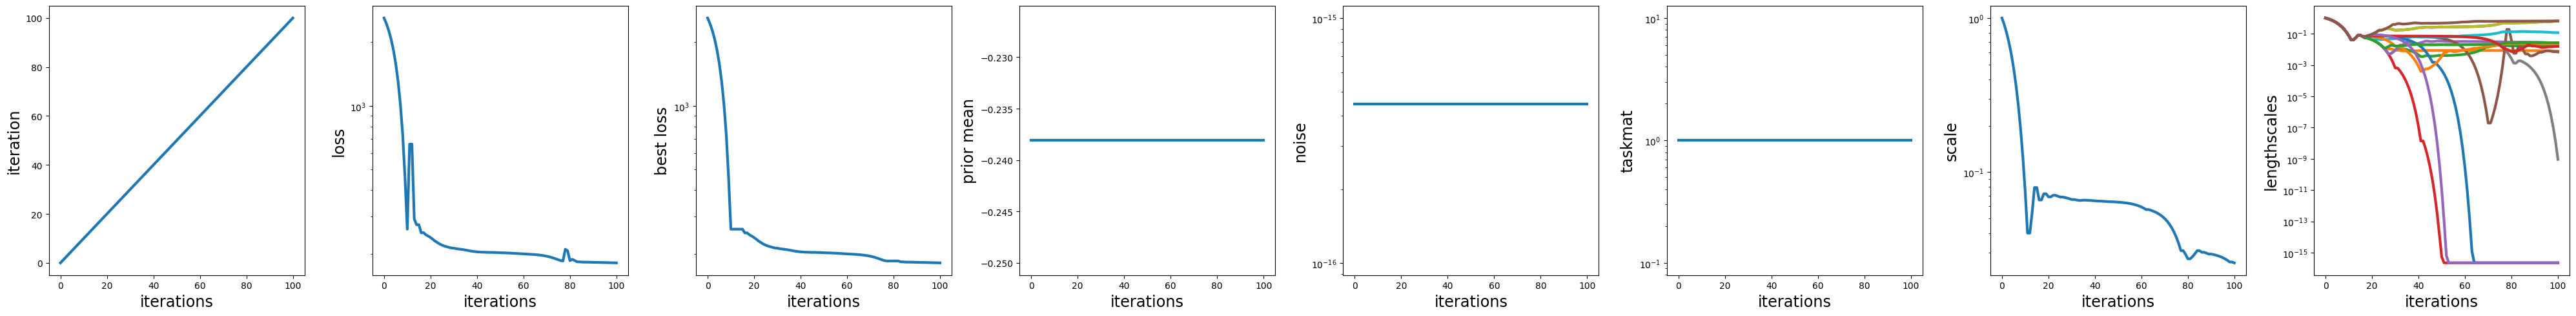

In [8]:
print("FIGPs-Lattice")
print("~"*25)
lattice_samplers_figps = qp.Lattice(d[0],seed=7)
lattice_samplers_figps = [lattice_samplers_figps]+lattice_samplers_figps.spawn(s=levels-1,dimensions=d[1:])
figps_lattice = [
    fastgps.FastGPLattice(
        kernel = qp.KernelShiftInvar(
            d = d[l],
            torchify = True,
            alpha = 2,
        ),
        seqs = lattice_samplers_figps[l],
    )
    for l in range(levels)
]
figps_lattice_approx = 0 
figps_lattice_std_error = 0 
for l in range(levels):
    x = figps_lattice[l].get_x_next(n=n[l]).numpy()
    y = fs[l].f(x)
    delta = y[1]-y[0]
    figps_lattice[l].add_y_next(torch.from_numpy(delta))
    fit_data = figps_lattice[l].fit(
        loss_metric = "MLL",
        stop_crit_improvement_threshold = 1e-3,
        iterations = 100,
        store_hists = True,
        verbose = False,
    )
    fastgps.plot_fastgps_fit_data(fit_data)
    figps_lattice_approx_l = figps_lattice[l].post_cubature_mean().numpy()
    figps_lattice_approx += figps_lattice_approx_l
    figps_lattice_std_error_l = np.sqrt(figps_lattice[l].post_cubature_var().numpy())
    figps_lattice_std_error = np.sqrt(figps_lattice_std_error**2+figps_lattice_std_error_l**2)
    figps_lattice_true_error_l = np.abs(figps_lattice_approx_l-exact_diffs[l])
    figps_lattice_true_error = np.abs(figps_lattice_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(figps_lattice_true_error,figps_lattice_std_error,figps_lattice_approx,figps_lattice_true_error_l,figps_lattice_std_error_l,figps_lattice_approx_l,x.shape,y.shape,delta.shape))

### Net

FIGPs-Net
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 1.72e+00   std_error = 8.64e-04   approx = 5.8849     error_l = 1.04e-03   std_error_l = 8.64e-04   approx_l = 5.8849     x.shape = (16384, 2)	y.shape = (2, 16384)	delta.shape = (16384,)  
error = 7.16e-01   std_error = 2.02e-03   approx = 4.8827     error_l = 5.99e-04   std_error_l = 1.83e-03   approx_l = -1.0022    x.shape = (4096, 4) 	y.shape = (2, 4096) 	delta.shape = (4096,)   
error = 2.35e-01   std_error = 4.39e-03   approx = 4.4023     error_l = 6.96e-05   std_error_l = 3.89e-03   approx_l = -0.4804    x.shape = (1024, 8) 	y.shape = (2, 1024) 	delta.shape = (1024,)   
error = 3.42e-03   std_error = 1.27e-02   approx = 4.1637     error_l = 3.05e-03   std_error_l = 1.19e-02   approx_l = -0.2386    x.shape = (256, 16) 	y.shape = (2, 256)  	delta.shape = (256,)    


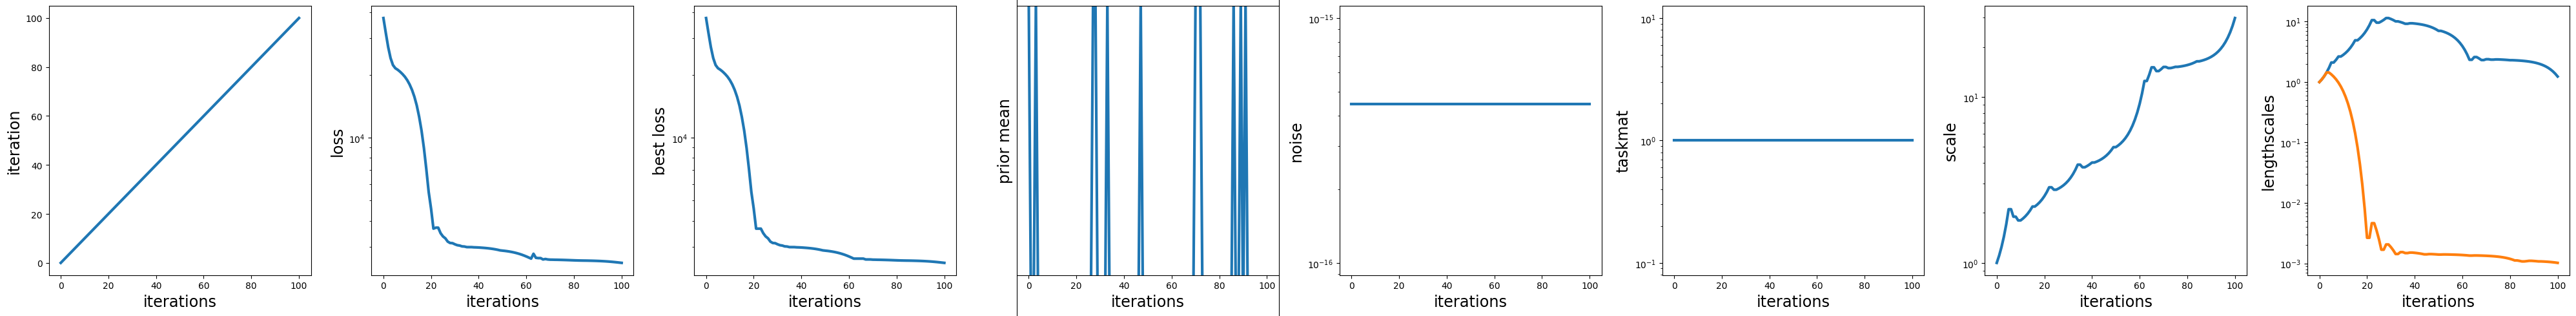

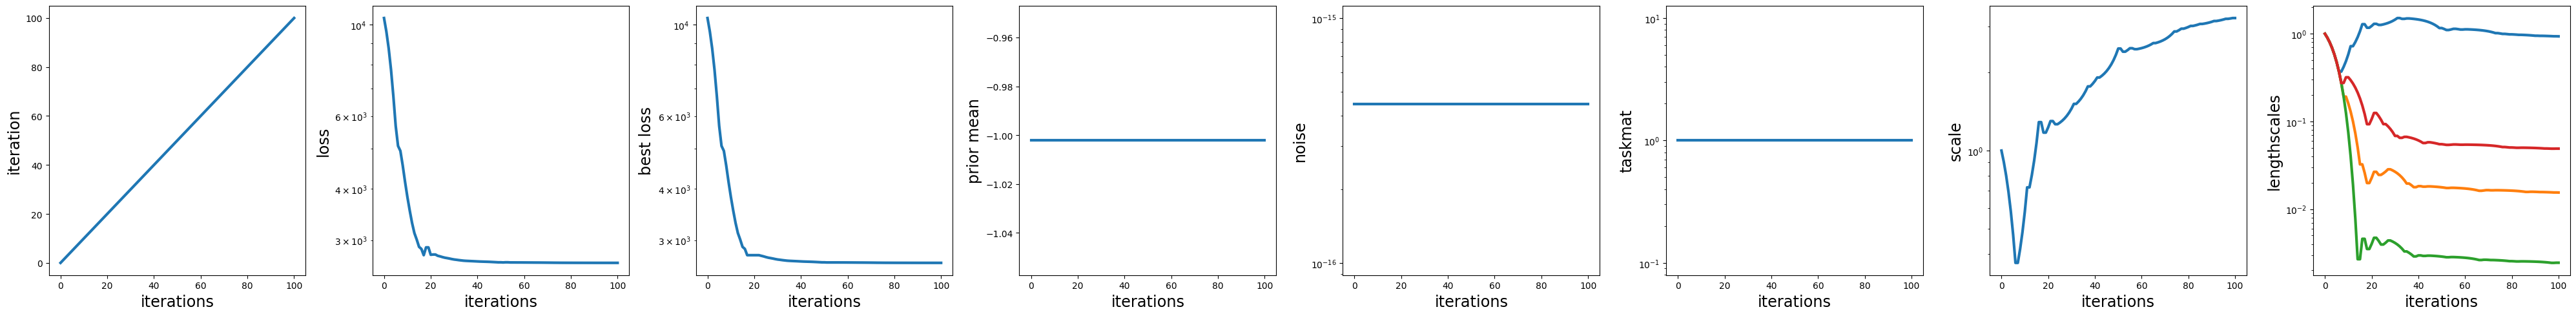

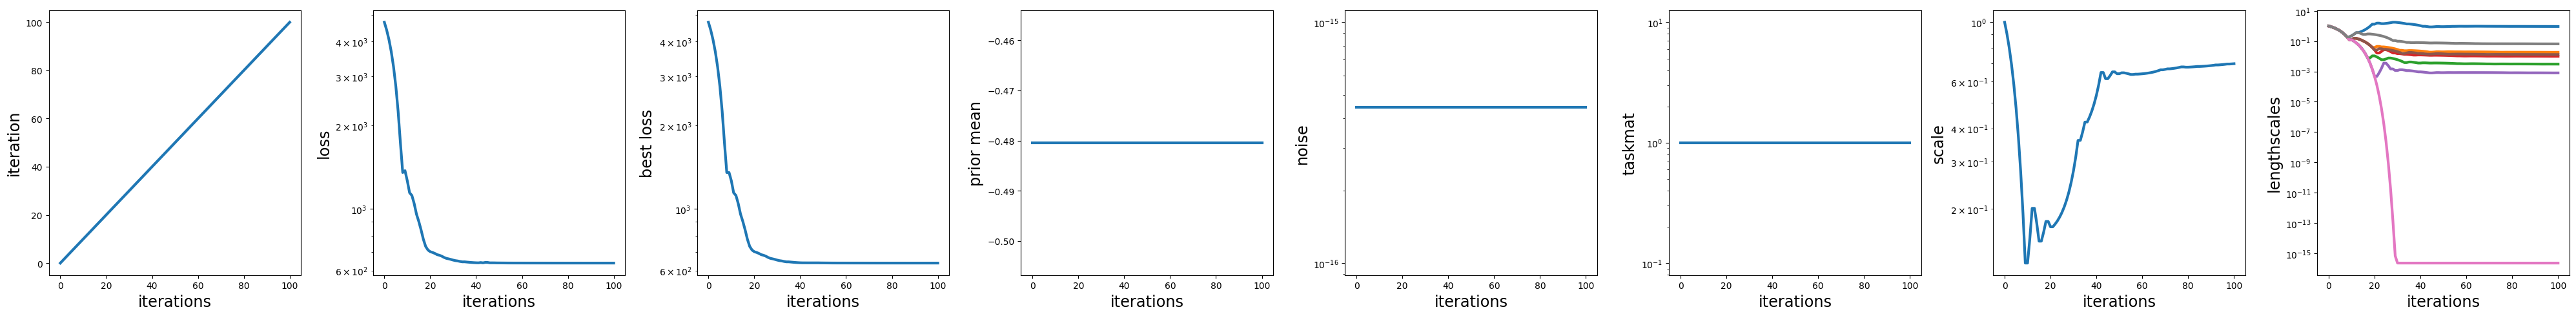

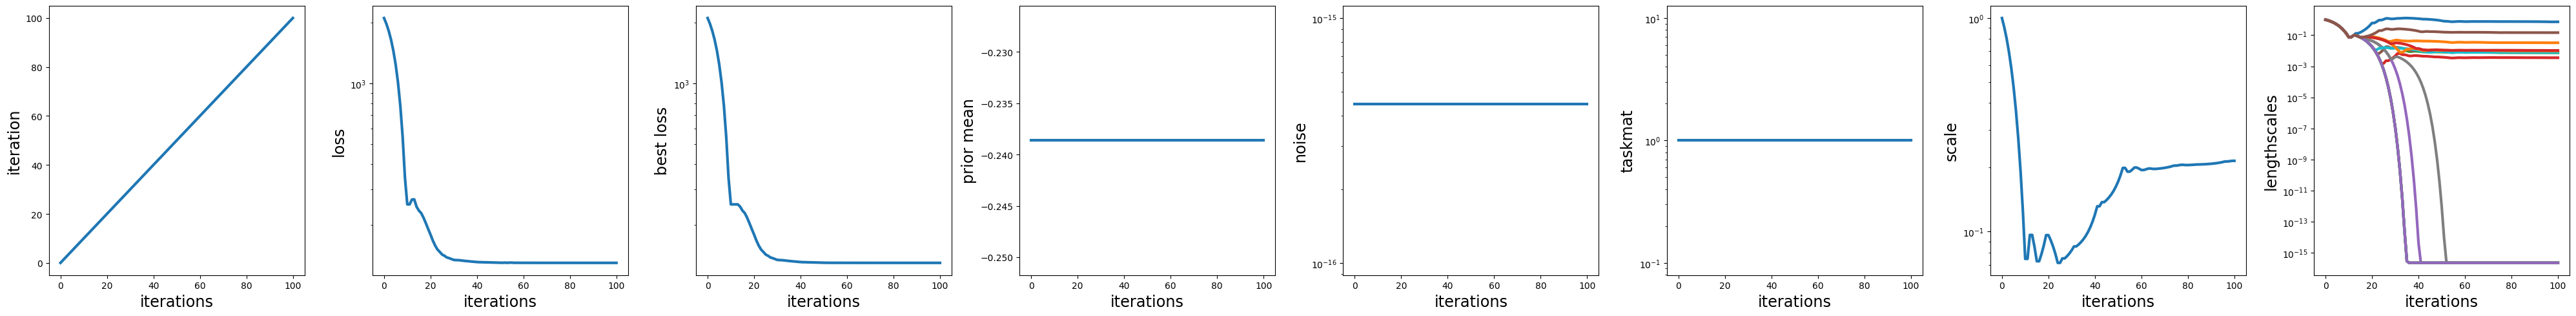

In [9]:
print("FIGPs-Net")
print("~"*25)
net_samplers_figps = qp.DigitalNet(d[0],seed=7)
net_samplers_figps = [net_samplers_figps]+net_samplers_figps.spawn(s=levels-1,dimensions=d[1:])
figps_net = [
    fastgps.FastGPDigitalNetB2(
        kernel = qp.KernelDigShiftInvar(
            d = d[l],
            torchify = True,
            alpha = 2
        ),
        seqs = net_samplers_figps[l],
    )
    for l in range(levels)
]
figps_net_approx = 0 
figps_net_std_error = 0 
for l in range(levels):
    x = figps_net[l].get_x_next(n=n[l]).numpy()
    y = fs[l].f(x)
    delta = y[1]-y[0]
    figps_net[l].add_y_next(torch.from_numpy(delta))
    fit_data = figps_net[l].fit(
        loss_metric = "MLL",
        stop_crit_improvement_threshold = 1e-3,
        iterations = 100,
        store_hists = True,
        verbose = False,
    )
    fastgps.plot_fastgps_fit_data(fit_data)
    figps_net_approx_l = figps_net[l].post_cubature_mean().numpy()
    figps_net_approx += figps_net_approx_l
    figps_net_std_error_l = np.sqrt(figps_net[l].post_cubature_var().numpy())
    figps_net_std_error = np.sqrt(figps_net_std_error**2+figps_net_std_error_l**2)
    figps_net_true_error_l = np.abs(figps_net_approx_l-exact_diffs[l])
    figps_net_true_error = np.abs(figps_net_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(figps_net_true_error,figps_net_std_error,figps_net_approx,figps_net_true_error_l,figps_net_std_error_l,figps_net_approx_l,x.shape,y.shape,delta.shape))

## Fast Multitask GPs modeling Differences

### Lattice

FMTGPs-Diff-Lattice
~~~~~~~~~~~~~~~~~~~~~~~~~
     iter of 1.0e+02 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.38e+05   | 2.38e+05  
            1.00e+01 | 7.43e+04   | 7.65e+04  
            2.00e+01 | 7.06e+04   | 7.06e+04  
            3.00e+01 | 6.84e+04   | 6.84e+04  
            4.00e+01 | 6.38e+04   | 6.38e+04  
            5.00e+01 | 6.30e+04   | 6.30e+04  
            6.00e+01 | 6.29e+04   | 6.29e+04  
            7.00e+01 | 6.28e+04   | 6.28e+04  
            8.00e+01 | 6.27e+04   | 6.27e+04  
            9.00e+01 | 6.27e+04   | 6.27e+04  
            1.00e+02 | 6.27e+04   | 6.27e+04  
error = 6.00e-03   std_error = 6.77e-02   approx = 4.1731     error_l = 8.17e-04   std_error_l = nan        approx_l = 5.8868    
error = 6.00e-03   std_error = 6.77e-02   approx = 4.1731     error_l = 2.64e-03   std_error_l = nan        approx_l = -1.0054   
error = 6.00e-03   std_error = 6.77e-02   approx = 4.1731     error_l = 9.24e-03   

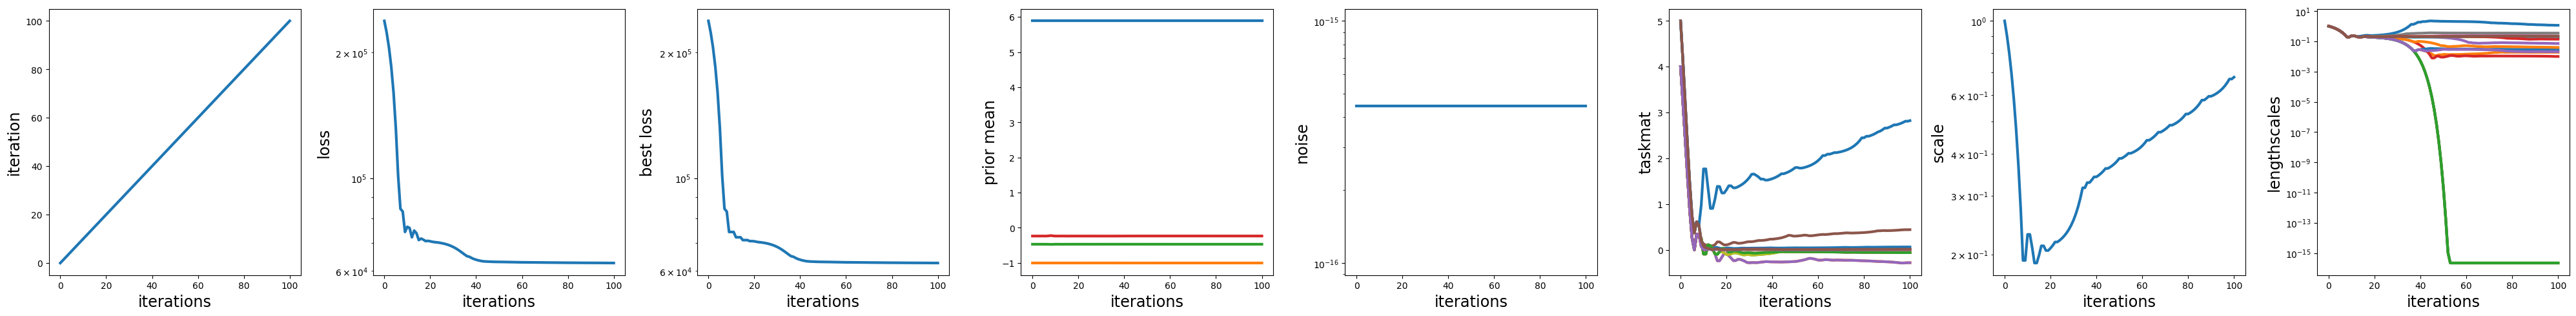

In [10]:
print("FMTGPs-Diff-Lattice")
print("~"*25)
lattice_samplers_mtgps = qp.Lattice(d[-1],seed=7)
lattice_samplers_mtgps = [lattice_samplers_mtgps]+lattice_samplers_mtgps.spawn(s=levels-1)
fmtgpds_lattice = fastgps.FastGPLattice(
    kernel = qp.KernelMultiTask(
        qp.KernelShiftInvar(
            d = d[-1],
            torchify = True,
            alpha = 2,
        ),
        num_tasks = levels,
        rank_factor = levels,
    ),
    seqs = lattice_samplers_mtgps,
)
for l in range(levels):
    x = fmtgpds_lattice.get_x_next(n=n[l],task=l).numpy()
    y = fs[l].f(x[...,:d[l]])
    delta = y[1]-y[0]
    fmtgpds_lattice.add_y_next(torch.from_numpy(delta),task=l)
fit_data = fmtgpds_lattice.fit(
    loss_metric = "MLL",
    stop_crit_improvement_threshold = 1e-3,
    iterations = 100,
    store_hists = True,
    verbose = 10,
)
fastgps.plot_fastgps_fit_data(fit_data)
fmtgpds_lattice_means = fmtgpds_lattice.post_cubature_mean().numpy()
fmtgpds_lattice_covs = fmtgpds_lattice.post_cubature_cov().numpy()
fmtgpds_lattice_approx = fmtgpds_lattice_means.sum()
fmtgpds_lattice_true_error = np.abs(fmtgpds_lattice_approx-exact_values[-1])
fmtgpds_lattice_std_error = np.sqrt(fmtgpds_lattice_covs.sum())
for l in range(levels):
    fmtgpds_lattice_approx_l = fmtgpds_lattice_means[l]
    fmtgpds_lattice_true_error_l = np.abs(fmtgpds_lattice_approx_l-exact_diffs[l])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f"\
          %(fmtgpds_lattice_true_error,fmtgpds_lattice_std_error,fmtgpds_lattice_approx,fmtgpds_lattice_true_error_l,np.nan,fmtgpds_lattice_approx_l))

## Net

FMTGPs-Diff-Net
~~~~~~~~~~~~~~~~~~~~~~~~~
     iter of 1.0e+02 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.97e+05   | 1.97e+05  
            1.00e+01 | 5.66e+04   | 5.66e+04  
            2.00e+01 | 2.97e+04   | 2.97e+04  
            3.00e+01 | 1.94e+04   | 1.94e+04  
            4.00e+01 | 1.62e+04   | 1.62e+04  
            5.00e+01 | 1.59e+04   | 1.59e+04  
            6.00e+01 | 1.59e+04   | 1.59e+04  
            7.00e+01 | 1.57e+04   | 1.57e+04  
            8.00e+01 | 1.56e+04   | 1.56e+04  
            9.00e+01 | 1.55e+04   | 1.55e+04  
            1.00e+02 | 1.54e+04   | 1.54e+04  
error = 2.63e-03   std_error = 2.88e-01   approx = 4.1698     error_l = 8.69e-04   std_error_l = nan        approx_l = 5.8868    
error = 2.63e-03   std_error = 2.88e-01   approx = 4.1698     error_l = 3.15e-04   std_error_l = nan        approx_l = -1.0025   
error = 2.63e-03   std_error = 2.88e-01   approx = 4.1698     error_l = 1.01e-03   std_

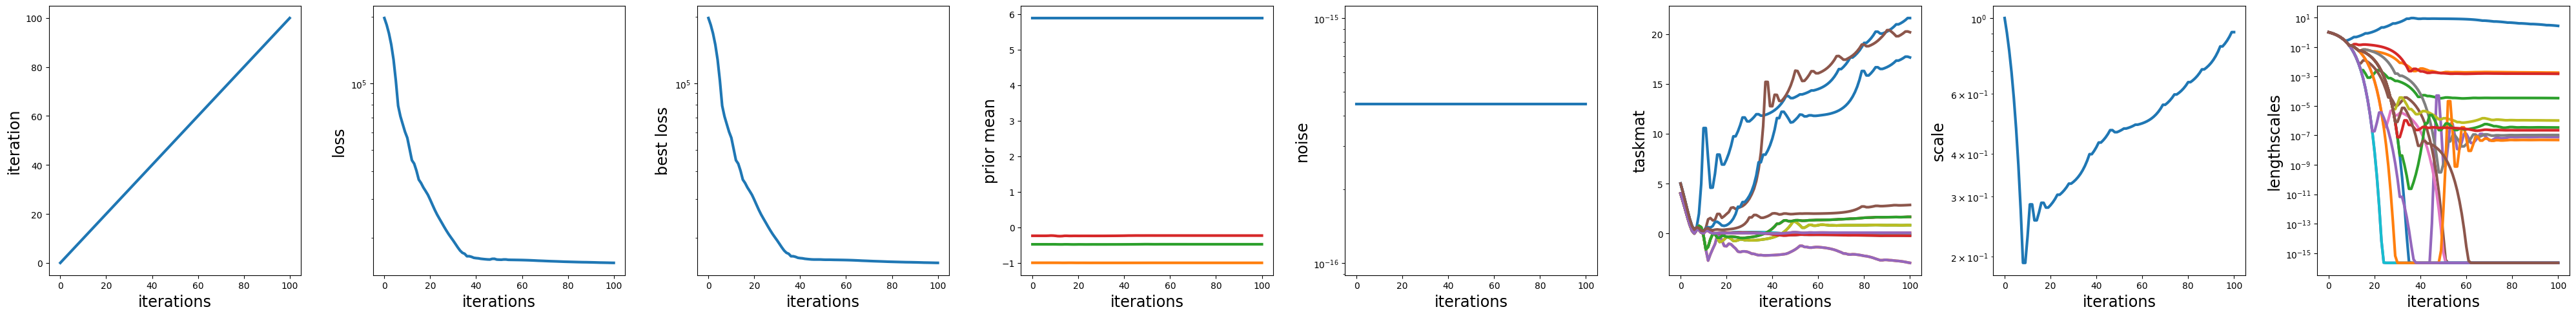

In [13]:
print("FMTGPs-Diff-Net")
print("~"*25)
net_samplers_mtgps = qp.DigitalNetB2(d[-1],randomize="DS",seed=7)
net_samplers_mtgps = [net_samplers_mtgps]+net_samplers_mtgps.spawn(s=levels-1)
fmtgpds_net = fastgps.FastGPDigitalNetB2(
    kernel = qp.KernelMultiTask(
        qp.KernelDigShiftInvar(
            d = d[-1],
            torchify = True,
            alpha = 2,
        ),
        num_tasks = levels,
        rank_factor = levels,
    ),
    seqs = net_samplers_mtgps,
)
for l in range(levels):
    x = fmtgpds_net.get_x_next(n=n[l],task=l).numpy()
    y = fs[l].f(x[...,:d[l]])
    delta = y[1]-y[0]
    fmtgpds_net.add_y_next(torch.from_numpy(delta),task=l)
fit_data = fmtgpds_net.fit(
    loss_metric = "MLL",
    stop_crit_improvement_threshold = 1e-3,
    iterations = 100,
    store_hists = True,
    verbose = 10,
)
fastgps.plot_fastgps_fit_data(fit_data)
fmtgpds_net_means = fmtgpds_net.post_cubature_mean().numpy()
fmtgpds_net_covs = fmtgpds_net.post_cubature_cov().numpy()
fmtgpds_net_approx = fmtgpds_net_means.sum()
fmtgpds_net_true_error = np.abs(fmtgpds_net_approx-exact_values[-1])
fmtgpds_net_std_error = np.sqrt(fmtgpds_net_covs.sum())
for l in range(levels):
    fmtgpds_net_approx_l = fmtgpds_net_means[l]
    fmtgpds_net_true_error_l = np.abs(fmtgpds_net_approx_l-exact_diffs[l])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f"\
          %(fmtgpds_net_true_error,fmtgpds_net_std_error,fmtgpds_net_approx,fmtgpds_net_true_error_l,np.nan,fmtgpds_net_approx_l))

## Fast Multitask GPs modeling Functions

### Lattice

FMTGPs-Func-Lattice
~~~~~~~~~~~~~~~~~~~~~~~~~
     iter of 1.0e+02 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.38e+05   | 2.38e+05  
            1.00e+01 | 7.79e+04   | 8.28e+04  
            2.00e+01 | 7.59e+04   | 7.59e+04  
            3.00e+01 | 7.16e+04   | 7.16e+04  
            4.00e+01 | 6.77e+04   | 6.77e+04  
            5.00e+01 | 6.74e+04   | 6.74e+04  
            6.00e+01 | 6.73e+04   | 6.73e+04  
            7.00e+01 | 6.72e+04   | 6.72e+04  
            8.00e+01 | 6.71e+04   | 6.71e+04  
            9.00e+01 | 6.69e+04   | 6.69e+04  
            1.00e+02 | 6.58e+04   | 6.58e+04  
error = 8.06e-02   std_error = 1.88e-01   approx = 4.0865     error_l = 8.17e-04   std_error_l = nan        approx_l = 5.8868    
error = 8.06e-02   std_error = 1.88e-01   approx = 4.0865     error_l = 4.43e-03   std_error_l = nan        approx_l = 4.8788    
error = 8.06e-02   std_error = 1.88e-01   approx = 4.0865     error_l = 2.54e-02   

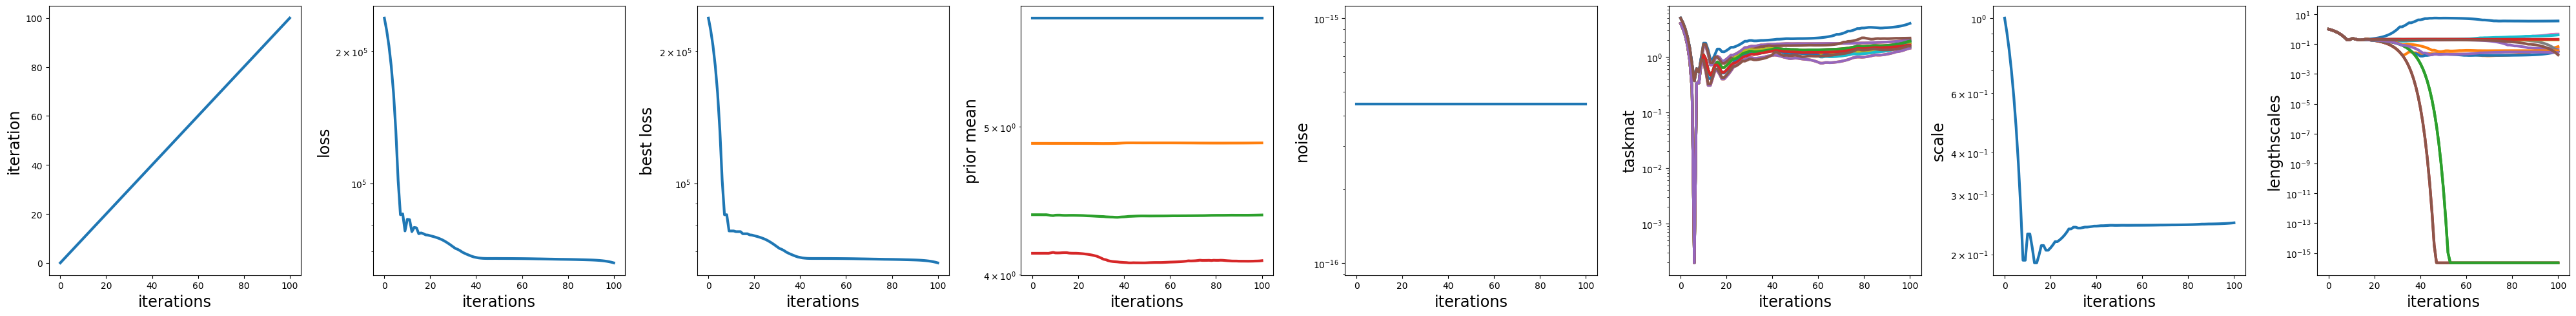

In [20]:
print("FMTGPs-Func-Lattice")
print("~"*25)
fmtgpfs_lattice = fastgps.FastGPLattice(
    kernel = qp.KernelMultiTask(
        qp.KernelShiftInvar(
            d = d[-1],
            torchify = True,
            alpha = 2,
        ),
        num_tasks = levels,
        rank_factor = levels,
    ),
    seqs = lattice_samplers_mtgps,
)
for l in range(levels):
    x = fmtgpfs_lattice.get_x_next(n=n[l],task=l).numpy()
    y = fs[l].f(x[...,:d[l]])
    delta = y[1]
    fmtgpfs_lattice.add_y_next(torch.from_numpy(delta),task=l)
fit_data = fmtgpfs_lattice.fit(
    loss_metric = "MLL",
    stop_crit_improvement_threshold = 1e-0,
    iterations = 100,
    store_hists = True,
    verbose = 10,
)
fastgps.plot_fastgps_fit_data(fit_data)
fmtgpfs_lattice_means = fmtgpfs_lattice.post_cubature_mean().numpy()
fmtgpfs_lattice_covs = fmtgpfs_lattice.post_cubature_cov().numpy()
fmtgpfs_lattice_approx = fmtgpfs_lattice_means[-1]
fmtgpfs_lattice_true_error = np.abs(fmtgpfs_lattice_approx-exact_values[-1])
fmtgpfs_lattice_std_error = np.sqrt(fmtgpfs_lattice_covs[-1,-1])
for l in range(levels):
    fmtgpfs_lattice_approx_l = fmtgpfs_lattice_means[l]
    fmtgpfs_lattice_true_error_l = np.abs(fmtgpfs_lattice_approx_l-exact_values[l+1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f"\
          %(fmtgpfs_lattice_true_error,fmtgpfs_lattice_std_error,fmtgpfs_lattice_approx,fmtgpfs_lattice_true_error_l,np.nan,fmtgpfs_lattice_approx_l))

## Net

FMTGPs-Func-Net
~~~~~~~~~~~~~~~~~~~~~~~~~
     iter of 1.0e+02 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.97e+05   | 1.97e+05  
            1.00e+01 | 4.85e+04   | 4.85e+04  
            2.00e+01 | 1.24e+04   | 1.24e+04  
            3.00e+01 | 9.26e+03   | 9.26e+03  
            4.00e+01 | 8.90e+03   | 8.90e+03  
            5.00e+01 | 8.73e+03   | 8.73e+03  
            6.00e+01 | 8.69e+03   | 8.69e+03  
            7.00e+01 | 8.59e+03   | 8.59e+03  
            8.00e+01 | 8.54e+03   | 8.54e+03  
            9.00e+01 | 8.53e+03   | 8.53e+03  
            1.00e+02 | 8.53e+03   | 8.53e+03  
error = 7.96e-03   std_error = 5.33e-02   approx = 4.1751     error_l = 8.69e-04   std_error_l = nan        approx_l = 5.8868    
error = 7.96e-03   std_error = 5.33e-02   approx = 4.1751     error_l = 2.31e-03   std_error_l = nan        approx_l = 4.8855    
error = 7.96e-03   std_error = 5.33e-02   approx = 4.1751     error_l = 3.74e-03   std_

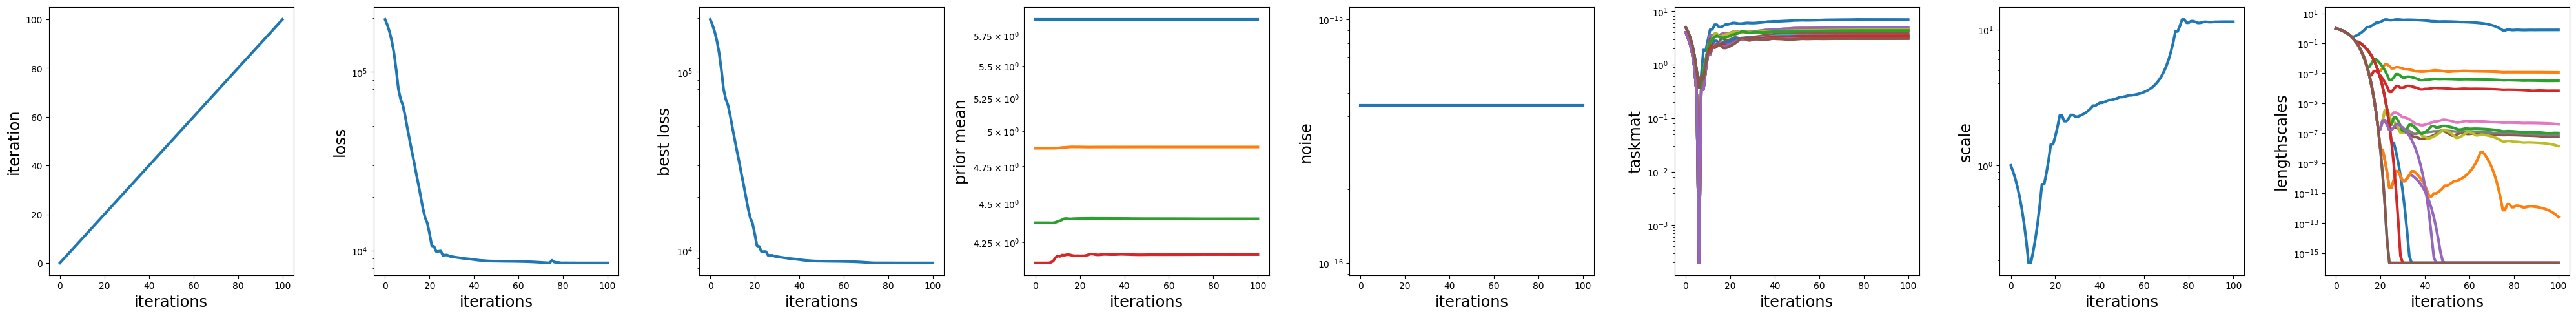

In [21]:
print("FMTGPs-Func-Net")
print("~"*25)
fmtgpfs_net = fastgps.FastGPDigitalNetB2(
    kernel = qp.KernelMultiTask(
        qp.KernelDigShiftInvar(
            d = d[-1],
            torchify = True,
            alpha = 2,
        ),
        num_tasks = levels,
        rank_factor = levels,
    ),
    seqs = net_samplers_mtgps,
)
for l in range(levels):
    x = fmtgpfs_net.get_x_next(n=n[l],task=l).numpy()
    y = fs[l].f(x[...,:d[l]])
    delta = y[1]
    fmtgpfs_net.add_y_next(torch.from_numpy(delta),task=l)
fit_data = fmtgpfs_net.fit(
    loss_metric = "MLL",
    stop_crit_improvement_threshold = 1e-0,
    iterations = 100,
    store_hists = True,
    verbose = 10,
)
fastgps.plot_fastgps_fit_data(fit_data)
fmtgpfs_net_means = fmtgpfs_net.post_cubature_mean().numpy()
fmtgpfs_net_covs = fmtgpfs_net.post_cubature_cov().numpy()
fmtgpfs_net_approx = fmtgpfs_net_means[-1]
fmtgpfs_net_true_error = np.abs(fmtgpfs_net_approx-exact_values[-1])
fmtgpfs_net_std_error = np.sqrt(fmtgpfs_net_covs[-1,-1])
for l in range(levels):
    fmtgpfs_net_approx_l = fmtgpfs_net_means[l]
    fmtgpfs_net_true_error_l = np.abs(fmtgpfs_net_approx_l-exact_values[l+1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f error_l = %-10.2e std_error_l = %-10.2e approx_l = %-10.4f"\
          %(fmtgpfs_net_true_error,fmtgpfs_net_std_error,fmtgpfs_net_approx,fmtgpfs_net_true_error_l,np.nan,fmtgpfs_net_approx_l))